# 决策树ID3算法

### 导入包

In [70]:
"""
@author: songwen
"""
from numpy import *
import numpy as np
import pandas as pd
from math import log
import matplotlib.pyplot as plt
import matplotlib

In [71]:
# matplotlib.rcParams['font.sans-serif'] = [u'SimHei']
# matplotlib.rcParams['axes.unicode_minus'] = False
'''
计算数据集的信息熵(Information Gain)增益函数(机器学习实战中信息熵叫香农熵)
'''


def calcInfoEnt(dataSet):  # 本题中Label类别     #dataSet每一列是一个属性(列末是Label)
    numEntries = len(dataSet)  # 每一行是一个样本,17行数据
    labelCounts = {}  # 给所有可能的分类创建字典labelCounts初值{key:value... }，便于统计A类多少个，B类多少个。

    for featVec in dataSet:  # 按行循环：即featVev取遍了数据集中的每一行
        currentLabel = featVec[-1]  # featVec[-1]取遍最后一列值即Label
        if currentLabel not in labelCounts.keys():  # 如果当前的Label在字典中还没有,发现未有的类别就创建它，就是发现一个类别就统计它。
            labelCounts[currentLabel] = 0  # 则先赋值0来创建这个词，字典形式。
        labelCounts[currentLabel] += 1  # 计数, 统计每类Label数量(这行不受if限制),值是1，键就+1计数，currentLabel没有就加进来，从0开始计数。

    InfoEnt = 0.0
    for key in labelCounts:  # 遍历每类Label
        prob = float(labelCounts[key]) / numEntries  # 各类Label熵累加
        InfoEnt -= prob * log(prob, 2)  # ID3用的信息增益公式，值越小，纯度越高。
    return InfoEnt


'''
对于离散特征: 取出该特征取值为value的所有样本
'''


def splitDiscreteDataSet(dataSet, axis, value):  # dataSet是当前结点(待划分)集合，列表
    # axis指示划分所依据的属性, 是划分属性的列号，如0,1,2...
    # value该属性用于划分的取值, 属性值对应字符串
    # 就是说，axis对划分属性，value是此属性的具体值a1,a2,a3...,根据这些属性值来划分训练集样本。
    # 比如：纹理-清晰 对应样本D1，纹理-稍糊对应样本D2，纹理-模糊样本D3.把当前数据集D给划分成3份。
    retDataSet = []  # 为return Data Set分配一个列表用来储存
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]  # 该特征之前的特征仍保留在样本dataSet中
            reducedFeatVec.extend(featVec[axis + 1:])  # 该特征之后的特征仍保留在样本dataSet中，extend()即添加列数！
            # 这两句意思是把当前划分axis列去掉，剩下的的样本集，如《机器学习》P77倒数第三段的例子所示。

            retDataSet.append(reducedFeatVec)  # 把这个样本加到list中,并去除掉本划分属性
    return retDataSet


'''
连续值可以循环作为划分点（个数不变），而离散值中被选取的最优划分点用过就扔掉，不再采用。
对于连续特征: 返回特征取值大于value的所有样本(以value为阈值将集合分成两部分)
'''


def splitContinuousDataSet(dataSet, axis, value):
    retDataSetG = []  # 将储存取值大于value的样本
    retDataSetL = []  # 将储存取值小于value的样本
    for featVec in dataSet:
        if featVec[axis] > value:  # 大于阈值，则符合的样本数据的列从[0,axis)U[axis+1,end),
            # 还是和离散值一样，去掉划分属性，只不过该划分属性是连续值而已。
            reducedFeatVecG = featVec[:axis]
            reducedFeatVecG.extend(featVec[axis + 1:])
            retDataSetG.append(reducedFeatVecG)  # 去掉划分属性列，合并成一个列表
        else:
            reducedFeatVecL = featVec[:axis]
            reducedFeatVecL.extend(featVec[axis + 1:])
            retDataSetL.append(reducedFeatVecL)
    return retDataSetG, retDataSetL  # 返回两个集合, 是含2个元素的tuple形式


'''
根据InfoGain选择当前最好的划分特征(以及对于连续变量还要选择以什么值划分)
'''


def chooseBestFeatureToSplit(dataSet, labels):
    numFeatures = len(dataSet[0]) - 1  # 第0行属性的个数为8，最后一个类别去掉
    baseEntropy = calcInfoEnt(dataSet)  # 计算数据集的信息熵
    bestInfoGain = 0.0;
    bestFeature = -1  # 初始化最佳划分点（最大信息增益值）和最佳特征
    bestSplitDict = {}  # 初始化最佳划分字典集合
    for i in range(numFeatures):
        # 遍历所有特征：下面这句是取每一行的第i个, 即得当前集合所有样本第i个feature的值
        featList = [example[i] for example in dataSet]
        # 判断是否为离散特征
        if not (type(featList[0]).__name__ == 'float' or type(featList[0]).__name__ == 'int'):
            ### 对于离散特征：求若以该特征划分的熵增
            uniqueVals = set(featList)  # 从列表中创建集合set(得列表唯一元素值)
            newEntropy = 0.0
            for value in uniqueVals:  # 遍历该离散特征每个取值，求第i列属性每个不同值的熵*他们的概率
                subDataSet = splitDiscreteDataSet(dataSet, i, value)  # 计算每个取值的信息熵
                prob = len(subDataSet) / float(len(dataSet))  # subDataSet是去掉符合划分属性值剩下的样本。
                newEntropy += prob * calcInfoEnt(subDataSet)  # 属性各取值的熵累加

            infoGain = baseEntropy - newEntropy  # 得到以该特征划分的熵增
        ### 对于连续特征：求若以该特征划分的熵增(区别：n个数据则需添n-1个候选划分点, 并选最佳划分点)
        else:
            # 产生n-1个候选划分点： 比如0.3,0.7,0.8 求出2个均值:0.5，0.75. 2个连续点变成1个划分点，3个连续值就是2个划分点,所以n个变成n-1个划分点。对此新序列考察最佳划分点即可。
            sortfeatList = sorted(featList)
            splitList = []  # 用来存放n-1个划分点
            for j in range(len(sortfeatList) - 1):  # 产生n-1个候选划分点
                splitList.append((sortfeatList[j] + sortfeatList[j + 1]) / 2.0)
            bestSplitEntropy = 10000  # 设定一个很大的熵值(之后用)
            # 遍历n-1个候选划分点: 求选第j个候选划分点划分时的熵增, 并选出最佳划分点
            for j in range(len(splitList)):  # 划分点已经是各个中位数
                value = splitList[j]
                newEntropy = 0.0
                DataSet = splitContinuousDataSet(dataSet, i, value)
                subDataSetG = DataSet[0]
                subDataSetL = DataSet[1]
                probG = len(subDataSetG) / float(len(dataSet))
                newEntropy += probG * calcInfoEnt(subDataSetG)
                probL = len(subDataSetL) / float(len(dataSet))
                newEntropy += probL * calcInfoEnt(subDataSetL)  # 某结点D去掉某划分属性后的信息熵
                if newEntropy < bestSplitEntropy:  # 刚开始默认第1个候选熵是最小，然后和后面的比较，小的就替换当前熵。
                    bestSplitEntropy = newEntropy
                    bestSplit = j  # 此时j个划分点的信息熵是最小
            bestSplitDict[labels[i]] = splitList[bestSplit]  # 字典记录当前连续属性的最佳划分点

            infoGain = baseEntropy - bestSplitEntropy  # 计算以该节点划分的熵增
        ### 在所有属性(包括连续和离散)中选择可以获得最大熵增的属性
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    # 若当前节点的最佳划分特征为连续特征，则需根据“是否小于等于其最佳划分点”进行二值化处理
    # 即将该特征改为“是否小于等于bestSplitValue”, 例如将“密度”变为“密度<=0.3815”
    # 注意：以下这段直接操作了原dataSet数据, 之前的那些float型的值相应变为0和1
    # 【为何这样做?】在函数createTree()末尾将看到解释，就是离散值的二值化处理。
    if type(dataSet[0][bestFeature]).__name__ == 'float' or \
            type(dataSet[0][bestFeature]).__name__ == 'int':
        bestSplitValue = bestSplitDict[
            labels[bestFeature]]  # 字典里键值对是最佳划分属性：对应的值 labels[bestFeature]是Density属性, bestSplitValue就是0.381499999
        labels[bestFeature] = labels[bestFeature] + '<=' + str(bestSplitValue)  # Density <= 0.38149999999999995
        for i in range(shape(dataSet)[0]):
            if dataSet[i][bestFeature] <= bestSplitValue:
                dataSet[i][bestFeature] = 1  # 若概该样本的density<=最佳划分点，就把该离散属性值改为1，否则改为0
            else:
                dataSet[i][bestFeature] = 0
    return bestFeature


'''
若特征已经划分完，节点下的样本还没有统一取值，则需要进行投票：计算每类Label个数, 取max者
'''


def majorityCnt(classList):
    # print(classList)
    classCount = {}  # 将创建键值为Label类型的字典
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0  # 第一次出现的Label加入字典
        classCount[vote] += 1  # 计数
    return max(classCount)


'''
    #主程序：递归产生决策树
    # dataSet：当前用于构建树的数据集, 最开始就是data_full，然后随着划分的进行越来越小。
    # labels：当前数据集中有的用于划分的类别

'''
numLine = numColumn = 2


def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]  # 把数据集的最后一列类别提取出来。
    # 递归停止条件1：当前节点所有样本属于同一类；(注：count()方法统计某元素在列表中出现的次数)，当然不要划分了，因为ID3决策树就是用来分类的，D里面全部是同一个类别，为什么还要分呢，已近划分好了呀！
    # print(classList)
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # 递归停止条件2：当前节点上样本集合为空集(即特征的某个取值上已经没有样本了)：
    global numLine, numColumn
    (numLine, numColumn) = shape(dataSet)  # 开始的时候为(17, 9)后面(5, 8)。。。
    if float(numLine) == 0:
        return 'empty'
    # 递归停止条件3：所有可用于划分的特征均使用过了，则调用majorityCnt()投票定Label；
    # 没有剩余属性可以用来进一步划分样本．在这种情况下．使用多数表决，将给定的结点转换成树叶，并以样本中元组个数最多的类别作为类别标记，同时也可以存放该结点样本的类别分布
    if float(numColumn) == 1:  # 只有一列属性了，当然没得划分属性了。
        return majorityCnt(classList)
    # 不停止时继续划分：
    bestFeat = chooseBestFeatureToSplit(dataSet, labels)  # 调用函数找出当前最佳划分特征是第几个
    bestFeatLabel = labels[bestFeat]  # 当前最佳划分特征
    myTree = {bestFeatLabel: {}}  # 树是以字典形式存储划分点和对应类别标签的。
    featValues = [example[bestFeat] for example in dataSet]  # 样本在bestFeature 下划分的所有属性
    uniqueVals = set(featValues)
    if type(dataSet[0][bestFeat]).__name__ == 'str':  # 数据集的第0行样本，第最佳划分属性列，对应属性值为‘str’类型的判断。
        currentlabel = labels_full.index(labels[bestFeat])  # 找到划分属性的列号。
        featValuesFull = [example[currentlabel] for example in dataSet]  # 所有该划分点的属性值
        uniqueValsFull = set(featValuesFull)  # 使得当前最佳划分点所有属性值可以囊括，如第一次是Texture的{'fuzzy', 'distinct', 'blur'}三个属性值.
    del (labels[bestFeat])  # 划分完后, 即当前特征已经使用过了, 故将其从“待划分特征集”中所对应的位置删去
    # 【递归调用】针对当前用于划分的特征(bestFeat)的每个取值，划分出一个子树。
    for value in uniqueVals:  # 遍历该特征【现存的】取值
        subLabels = labels[:]  # 删掉划分属性后剩下的lables 列表
        if type(dataSet[0][bestFeat]).__name__ == 'str':
            uniqueValsFull.remove(value)  # 划分后删去(从uniqueValsFull中删!)
        myTree[bestFeatLabel][value] = createTree(splitDiscreteDataSet(dataSet, bestFeat, value), subLabels)
        # 用splitDiscreteDataSet()是由于, 所有的连续特征在划分后都被我们定义的chooseBestFeatureToSplit()处理成离散取值了。
    if type(dataSet[0][bestFeat]).__name__ == 'str':  # 若该特征离散【更详见后注】
        for value in uniqueValsFull:  # 则可能有些取值已经不在【现存的】取值中了
            # 这就是上面为何从“uniqueValsFull”中删去
            # 因为那些现有数据集中没取到的该特征的值，保留在了其中
            myTree[bestFeatLabel][value] = majorityCnt(classList)
    return myTree



### 绘制树

In [72]:
decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    """绘制带箭头的节点"""
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', xytext=centerPt, textcoords='axes fraction',
                            va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)


def createPlot():
    """绘制树节点"""
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode('决策节点', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('叶节点', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()


def getNumLeafs(myTree):
    """获取叶节点的数目"""
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


def getTreeDepth(myTree):
    """获取树的层数"""
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth


def plotMidText(cntPt, parentPt, txtString):
    """在父子节点间填充文本信息"""
    xMid = (parentPt[0] - cntPt[0]) / 2 + cntPt[0]
    yMid = (parentPt[1] - cntPt[1]) / 2 + cntPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)


def plotTree(myTree, parentPt, nodeTxt):
    """绘制树形图"""
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1 + float(numLeafs)) / 2 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1 / plotTree.totalD


def createPlot(inTree):
    """创建绘图区"""
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()


In [73]:
'''生成树调用的语句'''  ###########################################################

from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)


### 数据离散化

In [74]:
from sklearn.preprocessing import KBinsDiscretizer
kbd = KBinsDiscretizer(strategy="uniform", n_bins=5, encode="ordinal")
df_transformed = kbd.fit_transform(df.iloc[:,0:4])
print(df_transformed)

[[1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 3. 0. 0.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 1. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [2. 4. 0. 0.]
 [1. 4. 0. 0.]
 [1. 3. 0. 0.]
 [1. 3. 0. 0.]
 [1. 3. 0. 0.]
 [1. 3. 0. 0.]
 [1. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 3. 0. 0.]
 [1. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [1. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [1. 2. 0. 0.]
 [1. 4. 0. 0.]
 [1. 4. 0. 0.]
 [0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 3. 0. 0.]
 [0. 2. 0. 0.]
 [1. 2. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 3. 0. 1.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [1. 3. 0. 0.]
 [0. 2. 0. 0.]
 [3. 2. 3. 2.]
 [2. 2. 2. 2.]
 [3. 2. 3. 2.]
 [1. 0. 2. 2.]
 [3. 1. 3. 2.]
 [1. 1. 2. 2.]
 [2. 2. 3. 3.]
 [0. 0. 1. 1.]
 [3. 1. 3. 2.]
 [1. 1. 2. 2.]
 [0. 0. 2. 1.]
 [2. 2. 2. 2.]
 [2. 0. 2. 1.]
 [2. 1. 3. 2.]
 [1. 1. 2. 2.]
 [3. 2. 2. 2.]
 [1. 2. 2.

In [75]:
print(kbd.bin_edges_)

[array([4.3 , 5.02, 5.74, 6.46, 7.18, 7.9 ])
 array([2.  , 2.48, 2.96, 3.44, 3.92, 4.4 ])
 array([1.  , 2.18, 3.36, 4.54, 5.72, 6.9 ])
 array([0.1 , 0.58, 1.06, 1.54, 2.02, 2.5 ])]


In [76]:
df.iloc[:,0:4]=df_transformed
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,1.0,3.0,0.0,0.0
1,0.0,2.0,0.0,0.0
2,0.0,2.0,0.0,0.0
3,0.0,2.0,0.0,0.0
4,0.0,3.0,0.0,0.0


In [81]:
df['species'] = iris.target
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 0:-1].values, df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
data_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
data_train = data_train.values.tolist()
labels = df.columns.values[0:-1].tolist()
print(labels)
myTree = createTree(data_train, labels)
# createPlot(myTree)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


###  预测数据

In [78]:
# 预测数据
df1 = pd.DataFrame(X_test)
df1.columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
result = []
import re

pattern = r'(.*)<=(.*)'
for hang in range(len(df1)):
    tmpTree = myTree
    while 1:
        key = str()
        for i in tmpTree:
            key = i
        mo = re.search(pattern, key, re.M | re.I)
        if mo:
            lie = mo.group(1)
            v = float(mo.group(2))
            if (df1[lie][hang] <= v):
                tmpTree = tmpTree[i][1]
            else:
                tmpTree = tmpTree[i][0]
        if (type(tmpTree) != dict):
            result.append(tmpTree)
            break
        # 正确率
df1['p_label'] = result
df1['t_label'] = y_test


def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)


acc = accuracy(y_test, result)

print('Percentage of Correct Predictions', acc)

Percentage of Correct Predictions 0.7631578947368421


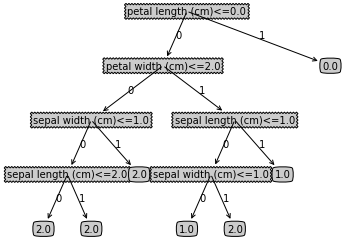

In [79]:
createPlot(myTree)

In [80]:
print(myTree)

{'petal length (cm)<=0.0': {0: {'petal width (cm)<=2.0': {0: {'sepal width (cm)<=1.0': {0: {'sepal length (cm)<=2.0': {0: 2.0, 1: 2.0}}, 1: 2.0}}, 1: {'sepal length (cm)<=1.0': {0: {'sepal width (cm)<=1.0': {0: 1.0, 1: 2.0}}, 1: 1.0}}}}, 1: 0.0}}
